# Heart Disease Dataset – EDA & Modeling

This notebook performs:

1. Data loading
2. Exploratory Data Analysis (EDA)
3. Preprocessing
4. Logistic Regression modeling
5. Evaluation and feature importance

Dataset: `data/heart.csv`
Target: `HeartDisease` (1 = disease, 0 = no disease)


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [4]:
data_path = os.path.join("..", "data", "heart.csv")  # adjust if notebook is elsewhere

df = pd.read_csv('/Users/jadavravi/Desktop/DA Projects/Heart Failure/Data/heart.csv')
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nNumeric summary:")
display(df.describe())

print("\nCategorical summary:")
display(df.describe(include="object"))

print("\nMissing values per column:")
print(df.isna().sum())


Shape: (918, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

Numeric summary:


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



Categorical summary:


,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460



Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Target value counts:
HeartDisease
1    508
0    410
Name: count, dtype: int64

Target distribution (%):
HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64


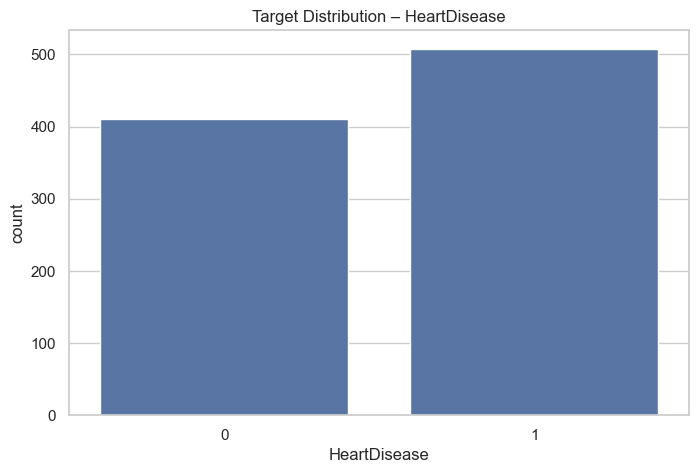

In [6]:
target_col = "HeartDisease"

print("Target value counts:")
print(df[target_col].value_counts())
print("\nTarget distribution (%):")
print(df[target_col].value_counts(normalize=True) * 100)

sns.countplot(x=target_col, data=df)
plt.title("Target Distribution – HeartDisease")
plt.show()


In [7]:
numeric_cols = df.select_dtypes(exclude="object").columns.tolist()
numeric_cols


['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'HeartDisease']

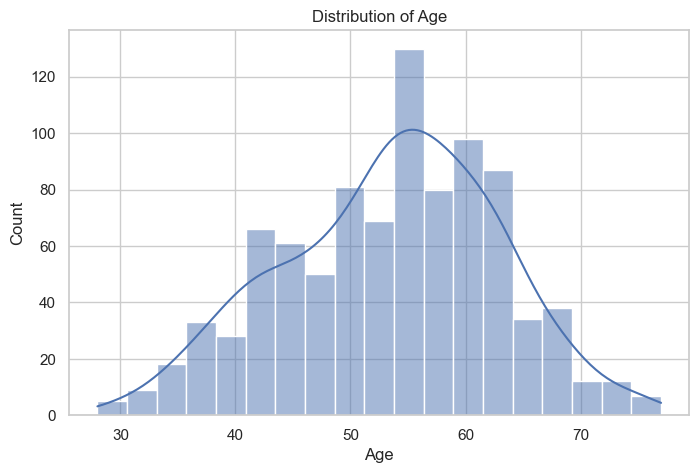

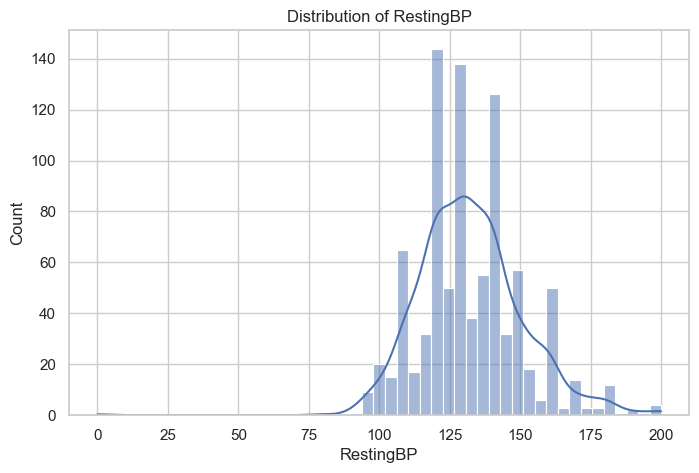

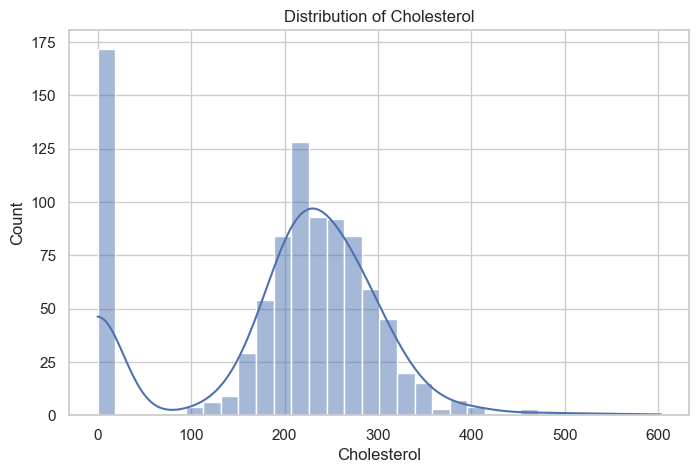

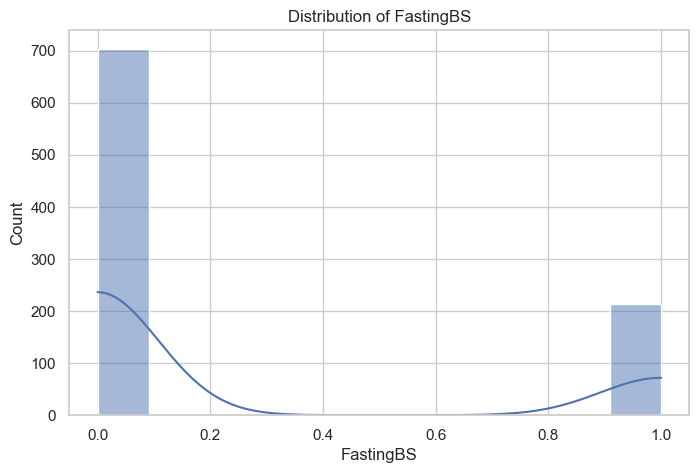

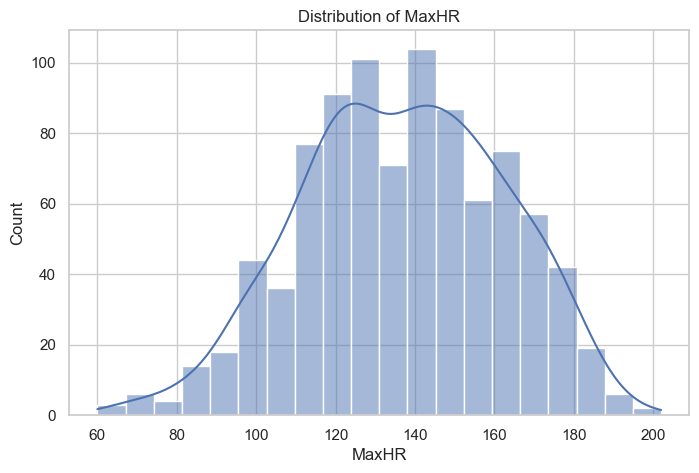

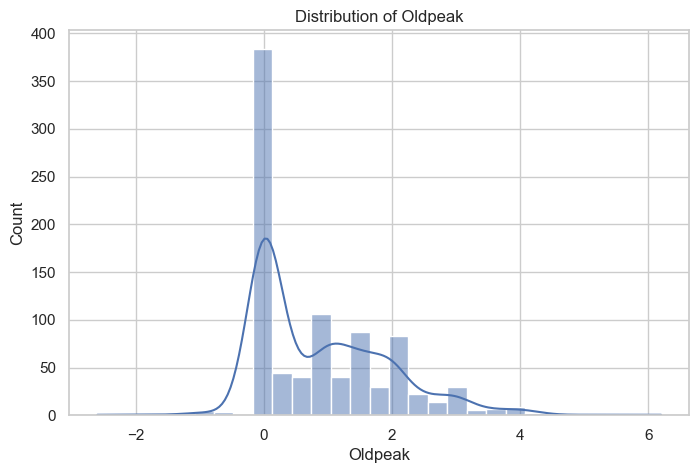

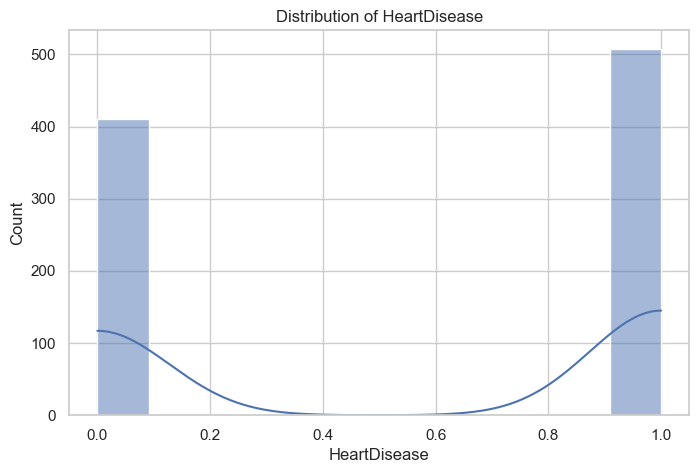

In [8]:
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


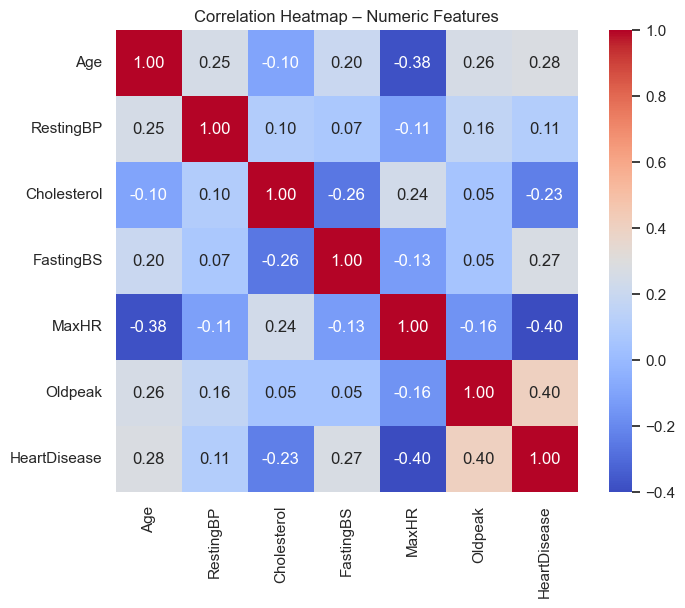

HeartDisease    1.000000
Oldpeak         0.403951
Age             0.282039
FastingBS       0.267291
RestingBP       0.107589
Cholesterol    -0.232741
MaxHR          -0.400421
Name: HeartDisease, dtype: float64

In [9]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap – Numeric Features")
plt.show()

corr[target_col].sort_values(ascending=False)


In [10]:
cat_cols = df.select_dtypes(include="object").columns.tolist()
cat_cols


['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


=== Sex vs HeartDisease (row-normalized) ===


HeartDisease,0,1
Sex,,
F,0.740933,0.259067
M,0.368276,0.631724


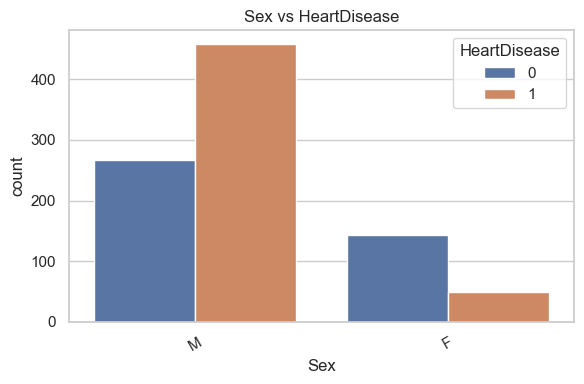


=== ChestPainType vs HeartDisease (row-normalized) ===


HeartDisease,0,1
ChestPainType,,
ASY,0.209677,0.790323
ATA,0.861272,0.138728
NAP,0.645320,0.354680
TA,0.565217,0.434783


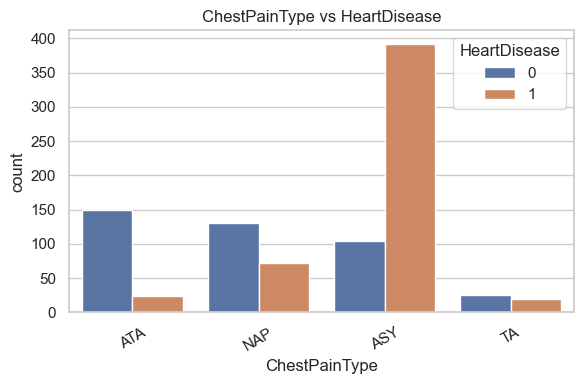


=== RestingECG vs HeartDisease (row-normalized) ===


HeartDisease,0,1
RestingECG,,
LVH,0.436170,0.563830
Normal,0.483696,0.516304
ST,0.342697,0.657303


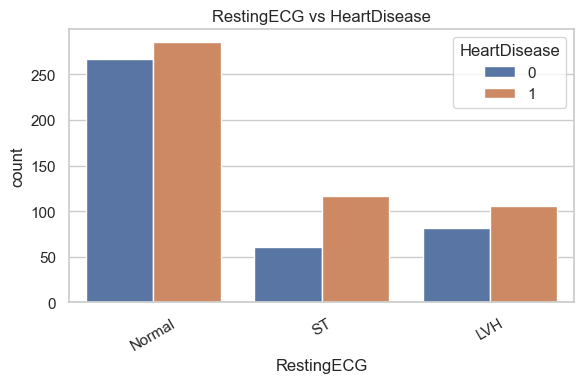


=== ExerciseAngina vs HeartDisease (row-normalized) ===


HeartDisease,0,1
ExerciseAngina,,
N,0.648995,0.351005
Y,0.148248,0.851752


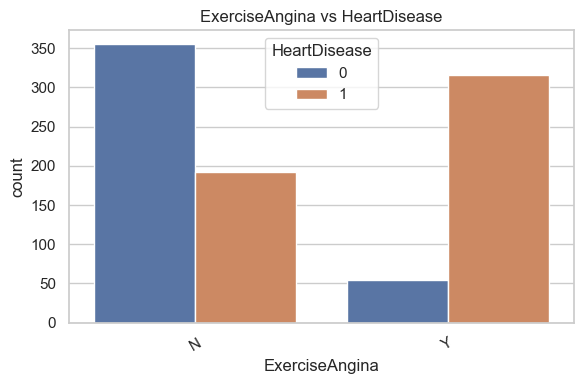


=== ST_Slope vs HeartDisease (row-normalized) ===


HeartDisease,0,1
ST_Slope,,
Down,0.222222,0.777778
Flat,0.171739,0.828261
Up,0.802532,0.197468


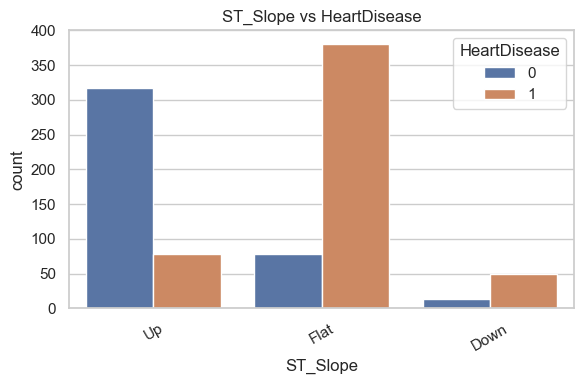

In [11]:
for col in cat_cols:
    print(f"\n=== {col} vs {target_col} (row-normalized) ===")
    ct = pd.crosstab(df[col], df[target_col], normalize="index")
    display(ct)

    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue=target_col, data=df)
    plt.title(f"{col} vs {target_col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


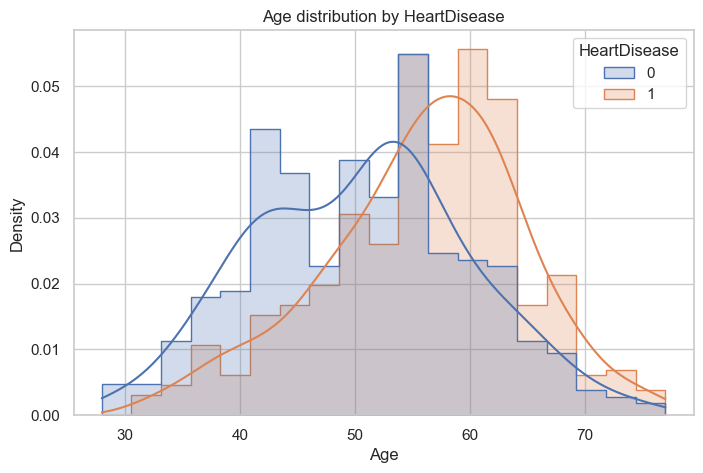

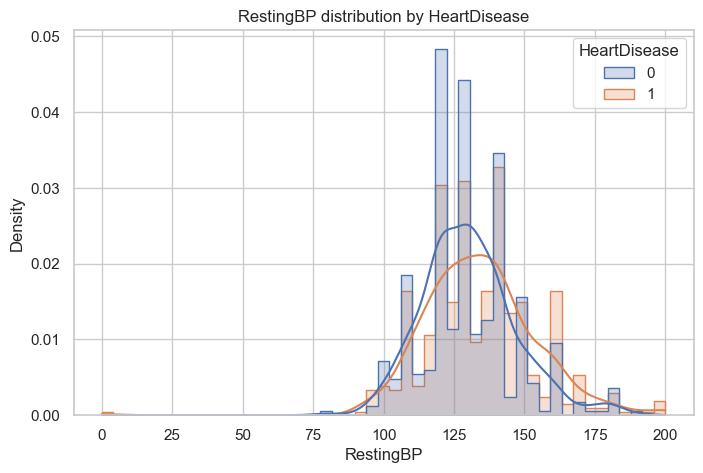

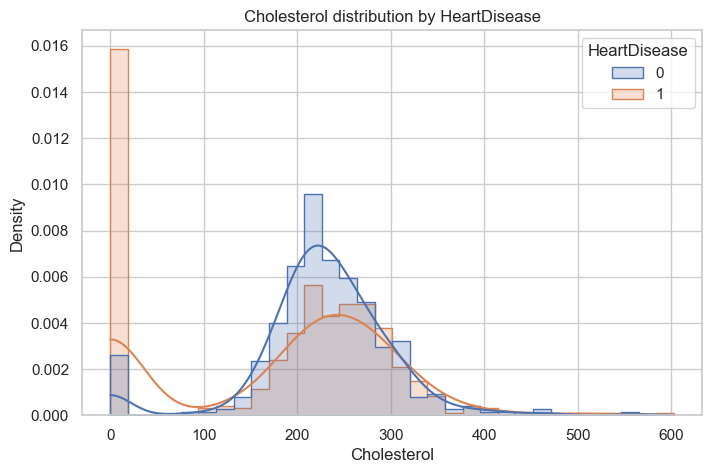

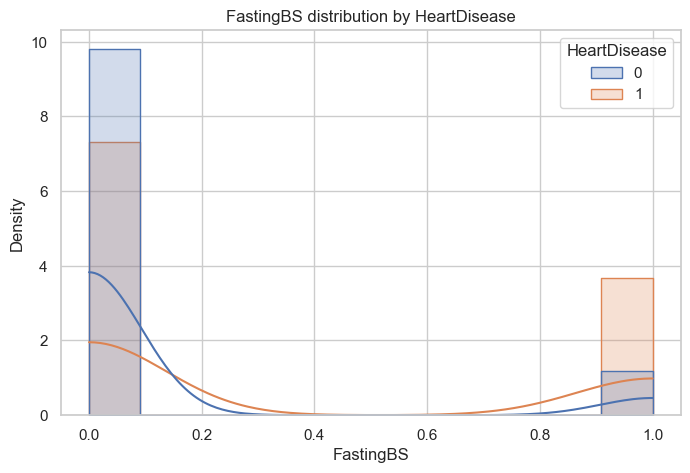

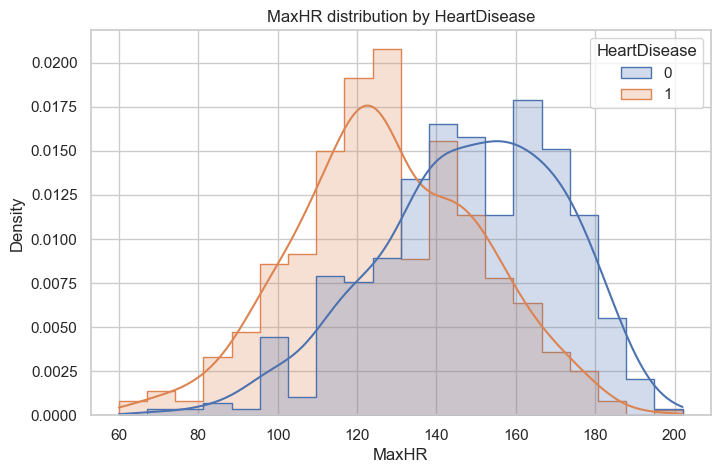

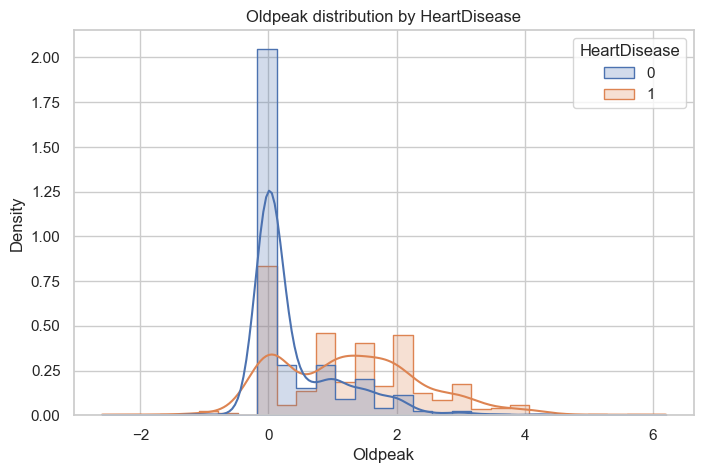

In [12]:
for col in numeric_cols:
    if col == target_col:
        continue
    plt.figure()
    sns.histplot(data=df, x=col, hue=target_col, kde=True, element="step", stat="density", common_norm=False)
    plt.title(f"{col} distribution by HeartDisease")
    plt.show()


In [13]:
# Features and target
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_features = X.select_dtypes(exclude="object").columns.tolist()
categorical_features = X.select_dtypes(include="object").columns.tolist()

numeric_features, categorical_features


(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'],
 ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

In [14]:
# Preprocessing
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Model
log_reg = LogisticRegression(max_iter=1000)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((734, 11), (184, 11))

In [15]:
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [16]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC: {auc:.3f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184


ROC-AUC: 0.930


In [17]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[68, 14],
       [ 7, 95]])

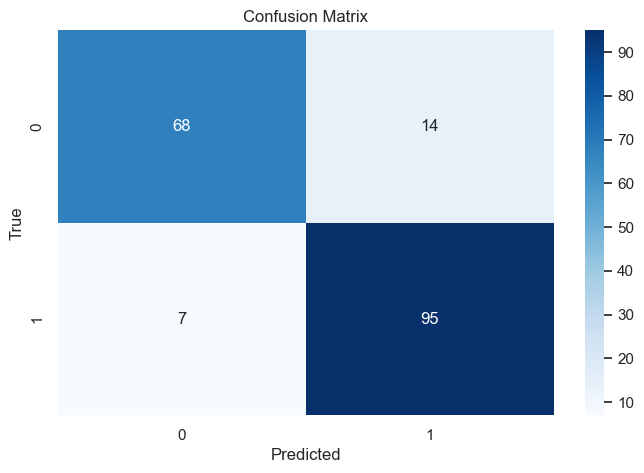

In [18]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# Extract trained model & preprocessor
model = clf.named_steps["model"]
pre = clf.named_steps["preprocess"]

# Get feature names
num_cols = pre.transformers_[0][2]
cat_transformer = pre.named_transformers_["cat"].named_steps["onehot"]
cat_cols = cat_transformer.get_feature_names_out(pre.transformers_[1][2])

feature_names = list(num_cols) + list(cat_cols)

coefs = model.coef_[0]
coef_series = pd.Series(coefs, index=feature_names).sort_values(ascending=False)

coef_series.head(10), coef_series.tail(10)


(ChestPainType_ASY    1.193180
 ST_Slope_Flat        1.089095
 Sex_M                0.531010
 FastingBS            0.430936
 ExerciseAngina_Y     0.398158
 Oldpeak              0.279759
 RestingECG_LVH       0.213749
 ST_Slope_Down        0.132189
 RestingBP            0.041825
 Age                  0.035357
 dtype: float64,
 RestingECG_Normal   -0.157079
 RestingECG_ST       -0.161188
 MaxHR               -0.186601
 ChestPainType_TA    -0.215932
 ChestPainType_ATA   -0.439494
 Cholesterol         -0.492059
 ExerciseAngina_N    -0.502676
 Sex_F               -0.635529
 ChestPainType_NAP   -0.642273
 ST_Slope_Up         -1.325803
 dtype: float64)

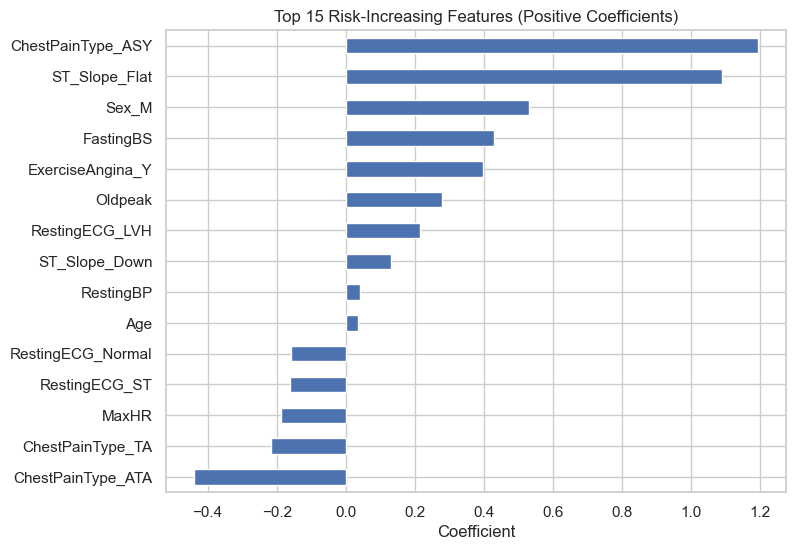

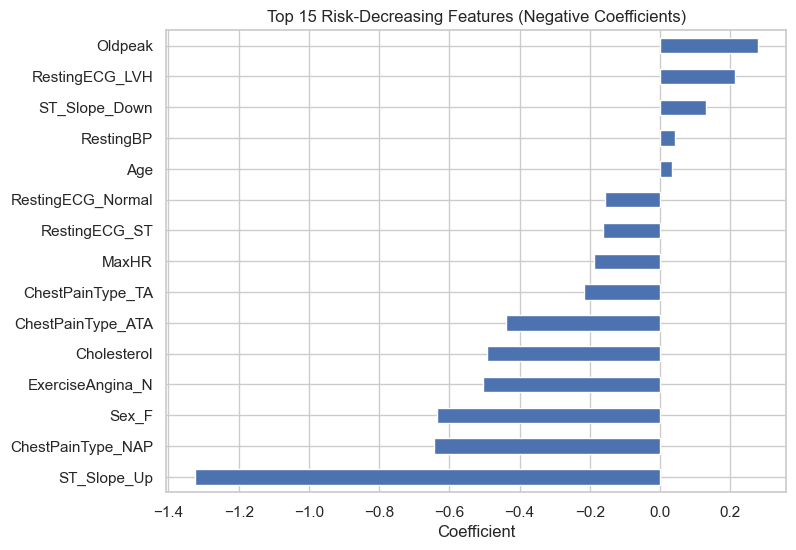

In [21]:
plt.figure(figsize=(8, 6))
coef_series.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Risk-Increasing Features (Positive Coefficients)")
plt.xlabel("Coefficient")
plt.show()

plt.figure(figsize=(8, 6))
coef_series.tail(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Risk-Decreasing Features (Negative Coefficients)")
plt.xlabel("Coefficient")
plt.show()


## Summary & Conclusions

**Key EDA insights:**

- The dataset is slightly imbalanced towards heart disease (~55% positive).
- Higher `Age`, `Oldpeak`, `FastingBS`, and lower `MaxHR` are associated with heart disease.
- Categorical risk signals:
  - `ChestPainType = ASY` is strongly associated with heart disease.
  - `ExerciseAngina = Y` and `ST_Slope` being `Flat` or `Down` show high proportions of heart disease.
  - `Sex = M` shows a higher rate of heart disease than `Sex = F`.

**Model performance (Logistic Regression):**

- Accuracy ≈ 0.88–0.89
- ROC-AUC ≈ 0.93
- Good recall for the positive class (HeartDisease = 1).

**Top risk-increasing features:**

- Asymptomatic chest pain (`ChestPainType_ASY`)
- Flat or down-sloping ST segment (`ST_Slope_Flat`, `ST_Slope_Down`)
- Exercise-induced angina (`ExerciseAngina_Y`)
- Male sex (`Sex_M`)
- Higher `Oldpeak` and `FastingBS`